In [1]:
import tensorflow as tf
print(tf.__version__)
print("gpu is ","available"if tf.test.is_gpu_available() else  "not AVAILABLE" )

2.0.2
gpu is  not AVAILABLE


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras  import layers
import time 
import glob

from IPython import display

In [3]:
#使用fashion mnist 进行Gan 的训练 生成器类似于 fashion_mnist 的数据集
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images -127.5)/127.5 #将图片标准化到【-1 ， 1】

In [5]:
buffer_size = 60000
batch_size = 256

In [6]:
#批量化 和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)


In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Convolution2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Convolution2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    assert model.output_shape == (None,28,28,1)
    
    return model


In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

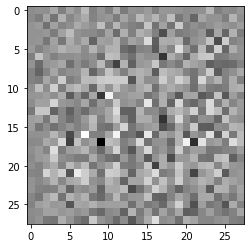

In [9]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [10]:
#构建判别器
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [11]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [12]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00119668]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [14]:
#判别器损失函数
def discriminator_loss(real_output,fake_output):
    #计算为真【【1】】和实际输出real_output的损失
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

In [15]:
#生成器损失函数
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
#定义检查点文件
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [18]:
#训练模型
epochs = 5
noise_dim = 100
num_examples_to_generate = 16

#产生随机种子
#后面将重复使用该种子 （因此在动画gif中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [19]:
#注意 tf.funtion 的使用 该注解函数  被编译为计算图模式
@tf.function()
def train_step(images):
    noise  =  tf.random.normal([batch_size,noise_dim])
    #tf.GradientTape()自动计算梯度的空间
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_image = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_image,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    
    '''
    训练在生成器接收到一个随机种子作为输入时开始，用于生产一张图片 判断器随后被用于区
    分真实图片（选自训练集）和伪造图片（生成器生成）。针对这里的每一个模型都计算损失函数
    并且计算梯度用于更新生成器与判别器
    
    '''
    
    

In [20]:
def generate_and_save_images(model,epoch,test_input):
    #注意 training 设定为false
    #因此 所有层都在推理模式下运行（batchnorm）
    predictions = model(test_input,training = False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
        plt.axis('off')
        
        
    plt.savefig('image_at_epoch_[:04d].png'.format(epoch))
    plt.show()

In [21]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        #生成图片
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        
        #每 5 epochs 进行一次存储
        if (epoch+1) % 5 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time -start))

In [24]:
%%time #将会给出cellde 代码运行一次所花费的时间

train(train_dataset,epochs)

UsageError: Can't use statement directly after '%%time'!


In [ ]:
#恢复最新的检查点

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(epochs)

In [ ]:
#合成训练 过程产生图像的gif图
import imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file,model='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue 
        image = imageio.imread(filename)
        writer.append_data(image)
        
    image = imageio.imread(filename)
    writer.append_data(image)